# Explore here

It's recommended to use this notebook for exploration purposes.

## Step 1: Install dependencies
Make sure you have the Python packages pandas and requests installed to work on the project. If you don't have these libraries installed, run the following in the console:

pip install pandas requests lxml

In [16]:
# Step 1: Install dependencies

!pip install lxml

#IMPORTANDO MÓDULOS NECESARIOS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ssl
import requests
import ssl
#PERMITE VISUALIZAR FACILMENTE LOS GRÁFICOS
%matplotlib inline
#ABRIR URL CON URLLIB.REQUEST
from urllib.request import urlopen
#BS4 - BEAUTIFUL SOUP VERSION 4
from bs4 import BeautifulSoup




[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


## Step 2: Download HTML
The HTML of the web page will be downloaded using the requests library, as we saw in the module's theory.

The web page we want to scrape is the following: https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify. Collect and store the scraped text from the web in a variable.

In [ ]:

url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"

# Create a request with browser headers
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

# Use requests library instead of urlopen
response = requests.get(url, headers=headers)
html = response.text

soup = BeautifulSoup(html, 'html.parser')
print(soup)


<!DOCTYPE html>

<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-available" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of Spotify streaming records - Wikipedia</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-fo

: 

: 

## Step 3: Transform the HTML
Using BeautifulSoup, analyze the HTML to find the structure containing the data (e.g., <table>, <li>, <div>, etc.).
If you are using Wikipedia and it contains a table, you can directly use pandas.read_html() to load it as a DataFrame.


In [ ]:
from io import StringIO


df_list = pd.read_html(StringIO(html))
print(f"Found {len(df_list)} tables on the page\n")

# Check each table to find the one you want
for i, table in enumerate(df_list):
    print(f"Table {i}: Shape {table.shape} - Columns: {list(table.columns)[:3]}")
    print(table.head(5))


Found 26 tables on the page

Table 0: Shape (101, 6) - Columns: ['Rank', 'Song', 'Artist(s)']
  Rank               Song                 Artist(s) Streams (billions)  \
0    1  "Blinding Lights"                The Weeknd              5.273   
1    2     "Shape of You"                Ed Sheeran              4.765   
2    3  "Sweater Weather"         The Neighbourhood              4.375   
3    4          "Starboy"  The Weeknd and Daft Punk              4.359   
4    5        "As It Was"              Harry Styles              4.243   

        Release date Ref.  
0   29 November 2019  [1]  
1     6 January 2017  [2]  
2    3 December 2012  [3]  
3  21 September 2016  [4]  
4       1 April 2022  [5]  
Table 1: Shape (14, 14) - Columns: [('Rank', 'Rank'), ('Artist', 'Artist'), ('Top 100', 'Total songs')]
  Rank         Artist     Top 100            Top 10       3 billion+ streams  \
  Rank         Artist Total songs Lead Feat.   Lead Feat.               Lead   
0    1     Bruno Mars        

: 

Step 4: Process the DataFrame
Next, clean the rows to obtain clean values by removing $ and B. Also, remove any rows that are empty or lack information.

## Step 4: Process the DataFrame
Next, clean the rows to obtain clean values by removing $ and B. Also, remove any rows that are empty or lack information.


In [ ]:

import re
table = soup.find("table")

list_rows = []
for row in table.find_all("tr"):
    cells = row.find_all(["td", "th"])
    if cells:  
        str_cells = str(cells)
        clean = re.compile('<.*?>')
        clean2 = (re.sub(clean, '', str_cells))
        clean3 = re.sub(r'\n', '', clean2)
        clean4 = re.sub(r'"', '', clean3)
        list_rows.append(clean4)

print(f"\nTotal rows processed: {len(list_rows)}")
print(f"First row: {list_rows[1]}")



Total rows processed: 102
First row: [1, Blinding Lights, The Weeknd, 5.273, 29 November 2019, [1]]


: 

## Step 5: Store the data in SQLite
Create an empty database instance and include the cleaned data in it, as we saw in the database module. Once you have an empty database:

Create the table.
Insert the values.
Commit the changes.

In [ ]:
# Step 5: Store the data in SQLite
# Create an empty database instance and include the cleaned data in it, as we saw in the database module. Once you have an empty database:

# Create the table.
# Insert the values.
# Commit the changes.

import sqlite3


conn = sqlite3.connect('spotify_songs.db')
cursor = conn.cursor()

# Create table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS songs (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        rank TEXT,
        song TEXT,
        artist TEXT,
        streams TEXT,
        release_date TEXT,
        reference TEXT
    )
''')

for row in list_rows:
    values = row.strip('[]').split(', ')
    if len(values) >= 6:
        values[5] = values[5] + ']'
    if len(values) >= 5:  
        cursor.execute('''
            INSERT INTO songs (rank, song, artist, streams, release_date, reference)
            VALUES (?, ?, ?, ?, ?, ?)
        ''', values[:6])


conn.commit()

cursor.execute("SELECT COUNT(*) FROM songs")
count = cursor.fetchone()[0]
print(f"Successfully inserted {count} rows into the database")

cursor.execute("SELECT * FROM songs LIMIT 5")
for row in cursor.fetchall():
    print(row)

conn.close()


Successfully inserted 404 rows into the database
(1, 'Rank', 'Song', 'Artist(s)', 'Streams(billions)', 'Release date', 'Ref.')
(2, '1', '"Blinding Lights"', 'The Weeknd', '5.273', '29 November 2019', '[1')
(3, '2', '"Shape of You"', 'Ed Sheeran', '4.765', '6 January 2017', '[2')
(4, '3', '"Sweater Weather"', 'The Neighbourhood', '4.375', '3 December 2012', '[3')
(5, '4', '"Starboy"', 'The Weeknd and Daft Punk', '4.359', '21 September 2016', '[4')


: 

## Step 6: Visualize the data (optional, but highly recommended)
If you haven’t gone through the visualization concepts and practices yet, don’t worry. Try making this work, and we’ll explore visualization in depth in the next few projects.

What types of visualizations can we make? Suggest at least 3 and plot them.

In [ ]:
# Top 10 most streamed songs
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

conn = sqlite3.connect('spotify_songs.db')
df = pd.read_sql_query("SELECT * FROM songs", conn)
conn.close()

df['streams_numeric'] = pd.to_numeric(df['streams'], errors='coerce')

# Parse release dates
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(5))
print(f"\nBasic statistics:")
print(df[['streams_numeric', 'release_year']].describe())


Dataset shape: (404, 9)

First few rows:
   id  rank               song                    artist            streams  \
0   1  Rank               Song                 Artist(s)  Streams(billions)   
1   2     1  "Blinding Lights"                The Weeknd              5.273   
2   3     2     "Shape of You"                Ed Sheeran              4.765   
3   4     3  "Sweater Weather"         The Neighbourhood              4.375   
4   5     4          "Starboy"  The Weeknd and Daft Punk              4.359   

  release_date reference  streams_numeric  release_year  
0          NaT      Ref.              NaN           NaN  
1   2019-11-29        [1            5.273        2019.0  
2   2017-01-06        [2            4.765        2017.0  
3   2012-12-03        [3            4.375        2012.0  
4   2016-09-21        [4            4.359        2016.0  

Basic statistics:
       streams_numeric  release_year
count       396.000000    396.000000
mean          3.113273   2011.747475
std   

/var/folders/kb/wbs4qdcs1ddchlrdbsdgn_xm0000gn/T/ipykernel_80252/3849724362.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')


: 

# GRAPH 1: Top 10 Most Streamed Songs 

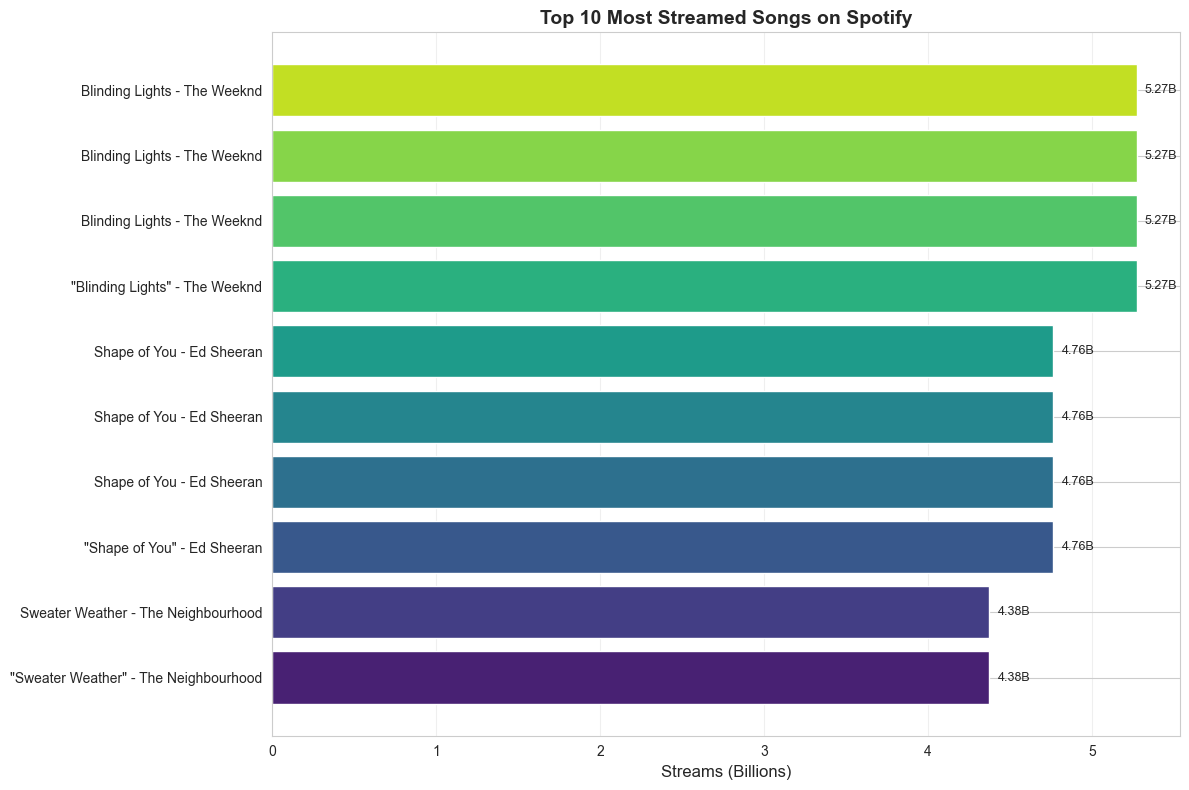

: 

In [ ]:


plt.figure(figsize=(12, 8))
top_10 = df.nlargest(10, 'streams_numeric')[['song', 'artist', 'streams_numeric']].sort_values('streams_numeric', ascending=True)


plt.barh(range(len(top_10)), top_10['streams_numeric'])
plt.yticks(range(len(top_10)), [f"{song} - {artist}" for song, artist in zip(top_10['song'], top_10['artist'])], fontsize=10)
plt.xlabel('Streams (Billions)', fontsize=12)
plt.title('Top 10 Most Streamed Songs on Spotify', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_10['streams_numeric']):
    plt.text(v + 0.05, i, f'{v:.2f}B', va='center', fontsize=9)

plt.tight_layout()
plt.show()


# GRAPH 2: Artistas con canciones en la lista de los Top 10 - Bar Chart

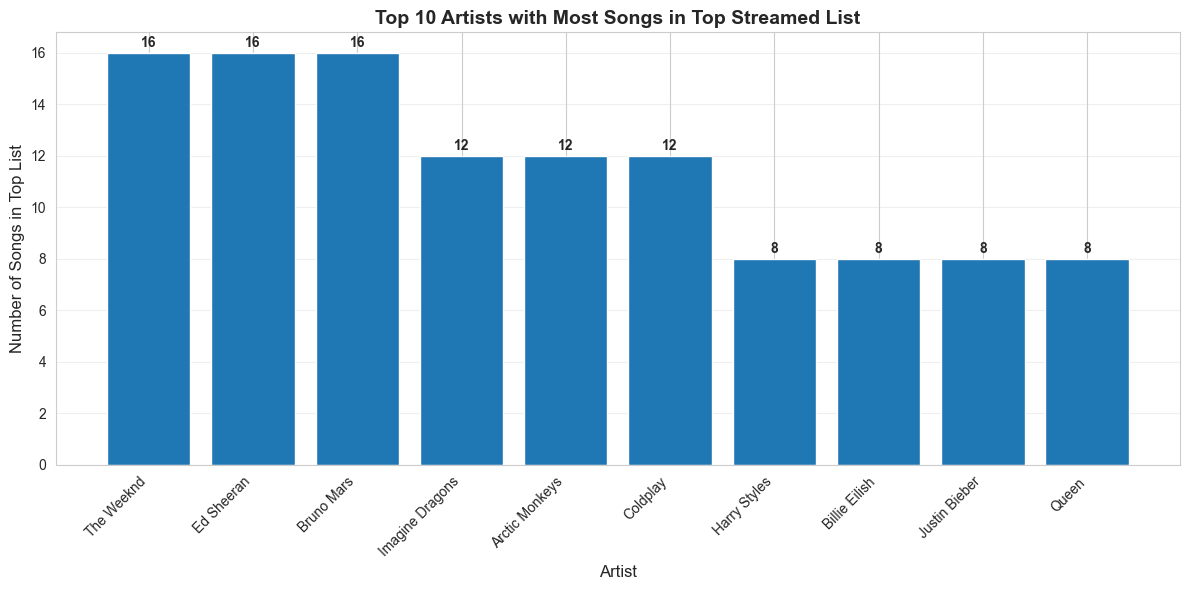

: 

In [ ]:

plt.figure(figsize=(12, 6))
#select los artistas en la Lista Top 10
artist_counts = df['artist'].value_counts().head(10)

plt.bar(range(len(artist_counts)), artist_counts.values)
plt.xticks(range(len(artist_counts)), artist_counts.index, rotation=45, ha='right', fontsize=10)
plt.xlabel('Artist', fontsize=12)
plt.ylabel('Number of Songs in Top List', fontsize=12)
plt.title('Top 10 Artists with Most Songs in Top Streamed List', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(artist_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


# GRAPH 3: Streams vs Release Year - Scatter Plot
Analizar la relacion entre el Release Year y las canciones escuchadas, si se escuchan mas las nuevas o las viejas


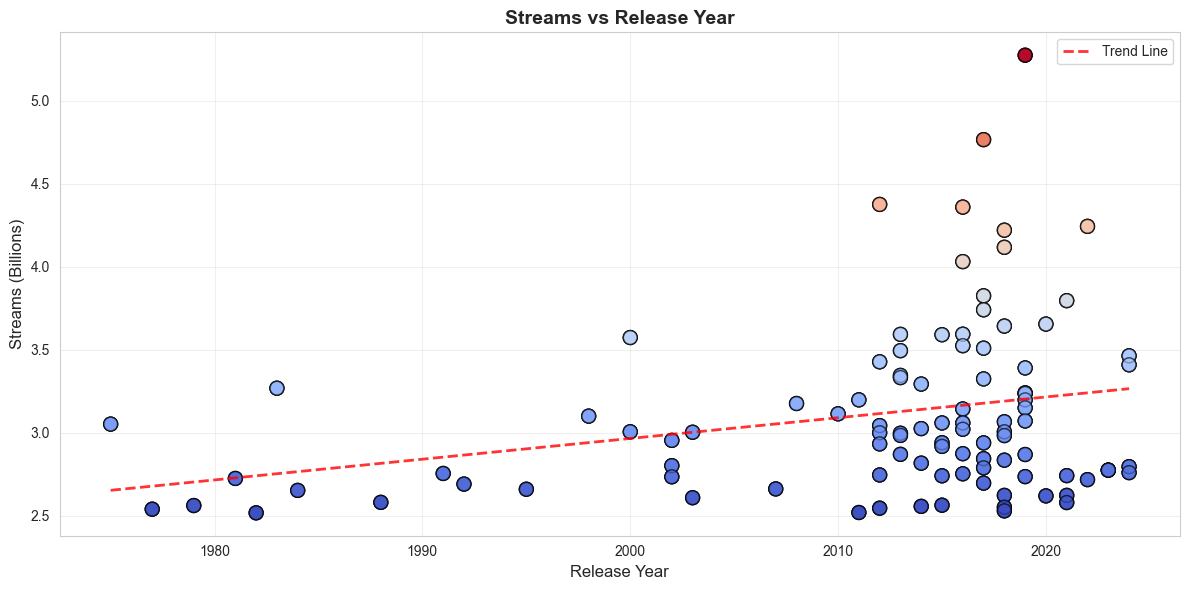

: 

In [ ]:

plt.figure(figsize=(12, 6))
df_clean = df.dropna(subset=['release_year', 'streams_numeric'])

scatter = plt.scatter(df_clean['release_year'], df_clean['streams_numeric'], 
                     c=df_clean['streams_numeric'], cmap='coolwarm', 
                     s=100, alpha=0.6, edgecolors='black')

plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Streams (Billions)', fontsize=12)
plt.title('Streams vs Release Year', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Streams (Billions)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
